In [1]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from skimage.io import*
from skimage.transform import*
from sklearn.decomposition import NMF 
from skimage.exposure import*
from skimage.util import*
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import cv2 

PyTorch version: 2.0.0+cu117
Torchvision version: 0.15.1+cu117
CUDA is available: True


In [2]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor     #facebook's segment anything

In [3]:
checkpoint = 'sam_vit_h_4b8939.pth'
model_type = 'vit_h'

In [4]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)
#sam.to('cuda')

In [5]:
img = imread("Contemporary-Modern-House-Design-6.1539270983.8601.jpg")

In [6]:
img.dtype

dtype('uint8')

In [7]:
mask_gen = SamAutomaticMaskGenerator(sam)

In [8]:
gen = mask_gen.generate(img)

In [9]:
import cv2 
import supervision as sv 

In [10]:
print(gen[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


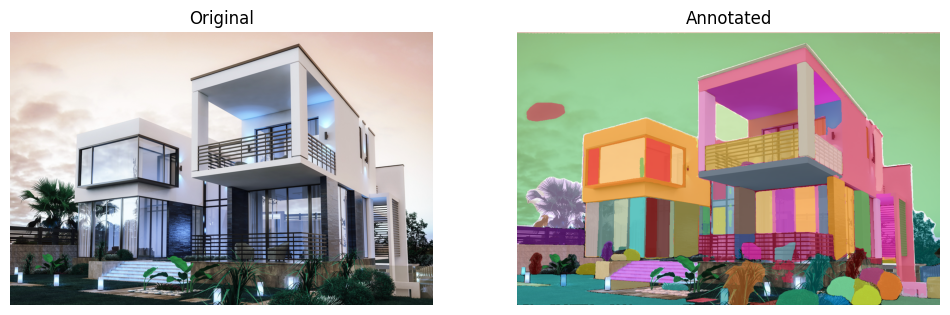

In [11]:
mask_annot = sv.MaskAnnotator()
detect = sv.Detections.from_sam(sam_result=gen)
annot = mask_annot.annotate(scene=img.copy(),detections=detect)
sv.plot_images_grid(images=[img,annot],grid_size=(1,2),titles=['Original','Annotated'])

In [12]:
msk_predictor = SamPredictor(sam)

In [13]:
from jupyter_bbox_widget import BBoxWidget

In [15]:
widget = BBoxWidget(
    image='Contemporary-Modern-House-Design-6.1539270983.8601.jpg ', # Input image location here
    classes=['trees','house'],
)
widget

BBoxWidget(classes=['trees', 'house'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b…

In [14]:
import os 

In [8]:
imagepath = 'Composite_slice8RB.jpg'

In [9]:
import base64 

In [10]:
# helper function that loads an image before adding it to the widget
def load_image(image_path):
    with open(image_path, 'rb') as f:
        data = f.read()
        encoded = str(base64.b64encode(data), 'utf-8')
    return "data:image/png;base64," + encoded

In [11]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = load_image(imagepath)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [16]:
widget.bboxes

[{'x': 30, 'y': 440, 'width': 156, 'height': 131, 'label': 'trees'},
 {'x': 192, 'y': 33, 'width': 973, 'height': 657, 'label': 'house'},
 {'x': 331, 'y': 633, 'width': 799, 'height': 161, 'label': 'trees'}]

In [34]:
box = widget.bboxes[2]
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

In [30]:
box 

array([ 192,   33, 1165,  690])

In [42]:
#extract all the bounding boxes from the widget
boxes = np.array([[
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
] for box in widget.bboxes])

In [18]:
import numpy as np 
import supervision as sv

In [43]:
msk_predictor.set_image(img)
for box in boxes:
    masks,scores,logits = msk_predictor.predict(box=box,multimask_output=False)
print(masks.shape)

(1, 800, 1240)


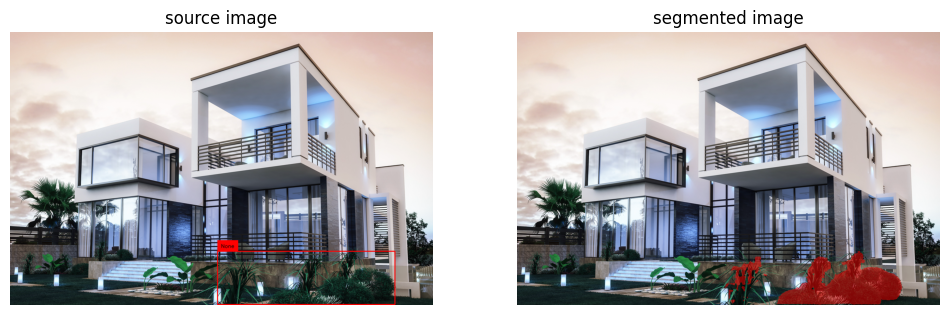

In [44]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=img.copy(), detections=detections, skip_label=False,labels=['house','trees'])
segmented_image = mask_annotator.annotate(scene=img.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)